## Air Quality Prediction Challenge
* Good cross validation: GroupKFold
* Drop all columns with more than 60% missing values
* Fill missing values using time series related techniques
* Drop country since they the same properties as the cities
* Drop highly correlated features greater than 0.9
* Cyclic features
* Datetime features


In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score , KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from sklearn.model_selection import GroupKFold
import catboost as catt
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

class Config:
    path = '/content/drive/MyDrive/Colab/Airqo_starter_notebook/'#/kaggle/input/airq0-lets-get-this/AirQ0/"
    id_col = "id"
    target_col = "pm2_5"

train = pd.read_csv(Config.path + "Train.csv")
test = pd.read_csv(Config.path + "Test.csv")

In [411]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]

    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)

    return data

train = remove_nans(train, 0.6)
test = remove_nans(test, 0.6)
train.shape, test.shape

((8071, 52), (2783, 72))

In [412]:
# Create folds before feature engineering
gkf = GroupKFold(n_splits = 4)
train['folds'] = np.nan
# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train.loc[test_index, 'folds'] = fold
# Convert fold indices to integer type
train['folds'] = train['folds'].astype(int)
train.groupby('folds')['pm2_5'].agg({'count'})


,count
folds,
1,5596
2,1500
3,852
4,123


In [413]:
# افترض أن train هي مجموعة البيانات الخاصة بك
# أولاً، تحقق من أنواع البيانات في مجموعة البيانات
# print(train.dtypes)

# حدد الأعمدة الرقمية فقط
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns

# حساب z-score للأعمدة الرقمية فقط
z = np.abs(stats.zscore(train[numeric_cols]))

# تعريف حد الأدنى لتحديد القيم الشاذة
threshold = 3

# تحديد الفهارس للقيم الشاذة لكل عمود رقمي
outlier_indices = []
for col in numeric_cols:
    outlier_indices.extend(np.where(z[col] > threshold)[0])

# إزالة الفهارس المكررة
outlier_indices = list(set(outlier_indices))

# طباعة عدد القيم الشاذة المحددة
print(f"Number of outliers identified: {len(outlier_indices)}")

# افترض أن test هي مجموعة البيانات الخاصة بك
# أولاً، تحقق من أنواع البيانات في مجموعة البيانات
# print(test.dtypes)

# حدد الأعمدة الرقمية فقط
numeric_cols = test.select_dtypes(include=['int64', 'float64']).columns

# حساب z-score للأعمدة الرقمية فقط
z = np.abs(stats.zscore(test[numeric_cols]))

# تعريف حد الأدنى لتحديد القيم الشاذة
threshold = 3

# تحديد الفهارس للقيم الشاذة لكل عمود رقمي
outlier_indices = []
for col in numeric_cols:
    outlier_indices.extend(np.where(z[col] > threshold)[0])

# إزالة الفهارس المكررة
outlier_indices = list(set(outlier_indices))

# طباعة عدد القيم الشاذة المحددة
print(f"Number of outliers identified: {len(outlier_indices)}")

Number of outliers identified: 218
Number of outliers identified: 58


In [414]:
train[(train['date']=='2023-10-25') & (train['city']=='Kampala')]

,id,site_id,site_latitude,site_longitude,city,country,date,hour,month,carbonmonoxide_co_column_number_density,...,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds
421,id_bnzz82vs1f,60d058c8048305120d2d6156,0.351700,32.591000,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,36683.276504,8415.787831,4.991480,0.307167,-99.635167,38.030097,-112.729436,33.768916,10.72830,1
568,id_hsain920tf,60d058c8048305120d2d615a,0.218200,32.617600,Kampala,Uganda,2023-10-25,11,10.0,0.033298,...,49297.640625,5987.647461,8.670818,0.184457,-99.659988,37.900917,-112.521225,33.712029,16.58720,1
825,id_hse0aqv6dj,616fe4ce9657420029658b3e,0.405320,32.620270,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,75042.937500,2625.331299,8.315380,0.346472,-99.614647,38.204361,-112.789452,33.809303,13.98560,1
1208,id_elqte0s1z1,64a5755320511a001d1b4a3e,0.329891,32.598999,Kampala,Uganda,2023-10-25,11,10.0,NaN,...,43098.839844,7044.871094,7.826046,0.259927,-99.651337,37.900677,-112.666084,33.735855,11.10380,1
1430,id_5pa9pq67xp,62b310512e0eca001e0aab11,0.298330,32.600740,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43138.459117,7037.917190,7.803655,0.259759,-99.648982,37.925970,-112.664331,33.739966,23.45730,1
1673,id_5xxfee2icn,60d058c8048305120d2d615c,0.356400,32.573000,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,32811.738281,9193.101563,4.563959,0.307819,-99.647224,37.900757,-112.738457,33.747902,47.34780,1
1934,id_fen86w6ue2,624d2f9a994194001ddccbb6,0.288630,32.602970,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43805.826209,6946.381884,7.491056,0.259607,-99.652445,37.900689,-112.647128,33.732724,15.57630,1
2198,id_5bylowr7h6,60d058c8048305120d2d6154,0.344000,32.553000,Kampala,Uganda,2023-10-25,11,10.0,NaN,...,32811.738281,9193.101562,4.563959,0.307819,-99.647224,37.900757,-112.738457,33.747902,24.33010,1
2711,id_j11a8zijyz,623d83620e8054001eaaa982,0.308520,32.592240,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43098.839844,7044.871094,7.826046,0.259927,-99.651337,37.900677,-112.666084,33.735855,25.06490,1
2915,id_f6jt57bht5,60d058c8048305120d2d6149,0.347014,32.649360,Kampala,Uganda,2023-10-25,11,10.0,0.034574,...,42207.379485,7323.031424,5.606781,0.306071,-99.618637,38.207406,-112.717067,33.797726,16.31450,1


In [415]:

def feature_engineering(train,test):
    train = train.fillna(method='ffill')
    test = test.fillna(method='ffill')
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')

    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week


    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])

#     data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train, test)


In [416]:
test_df[independent_features].isnull().sum()


date                                                        0
hour                                                        0
month                                                       0
carbonmonoxide_co_column_number_density                     0
carbonmonoxide_h2o_column_number_density                    0
carbonmonoxide_cloud_height                                 0
carbonmonoxide_sensor_altitude                              0
carbonmonoxide_sensor_azimuth_angle                         0
carbonmonoxide_sensor_zenith_angle                          0
carbonmonoxide_solar_azimuth_angle                          0
carbonmonoxide_solar_zenith_angle                           0
formaldehyde_tropospheric_hcho_column_number_density        0
formaldehyde_tropospheric_hcho_column_number_density_amf    0
formaldehyde_hcho_slant_column_number_density               0
formaldehyde_cloud_fraction                                 0
formaldehyde_solar_zenith_angle                             0
formalde

"""### Modelling : Stage 1"""

In [420]:
training  = train_df[train_df['folds'].isin([1.0,3.0, 4.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape


#### Visualize feature importanc


((6571, 79), (1500, 79))

In [421]:
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )


Learning rate set to 0.068433
0:	learn: 24.2725268	test: 25.8358055	best: 25.8358055 (0)	total: 13.3ms	remaining: 13.2s
100:	learn: 12.9049275	test: 25.1323577	best: 25.0834642 (33)	total: 1.99s	remaining: 17.7s
200:	learn: 9.9324273	test: 25.1749925	best: 25.0834642 (33)	total: 3.44s	remaining: 13.7s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 25.08346422
bestIteration = 33

Shrink model to first 34 iterations.


In [422]:
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted,
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
66,location,59.809001
3,carbonmonoxide_co_column_number_density,13.373239
0,date,3.849121
70,week,2.5542
32,ozone_solar_azimuth_angle,1.970295
23,uvaerosolindex_solar_azimuth_angle,1.795777
9,carbonmonoxide_solar_azimuth_angle,1.476604
29,ozone_cloud_fraction,1.476236
43,cloud_solar_azimuth_angle,1.433557
12,formaldehyde_tropospheric_hcho_column_number_d...,1.388729


In [423]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

len(non_zero_features)

45

In [424]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]
selected_columns

len(selected_columns)

31

In [425]:
old_pred = []
oof_pred = []

for fold in [1,2,3,4]:
    print("*" * 100)
    df_train = train_df.copy()
    df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

    training = df_train[train_df['folds'] != fold]
    validation = df_train[df_train['folds'] == fold]



    #training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
    model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 200, early_stopping_rounds = 250 )

    preds = model.predict(X_test)
    print(f"RMSE for fold :{fold} : {(mean_squared_error(preds, y_test, squared=False))}")
    oof_pred.append(mean_squared_error(preds, y_test, squared=False))

    #Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)



print(f"The average rmse across the 4 groups: {np.mean(oof_pred)}")

****************************************************************************************************
Learning rate set to 0.058707
0:	learn: 16.6132825	test: 13.1588337	best: 13.1588337 (0)	total: 21.3ms	remaining: 21.2s
200:	learn: 6.9633849	test: 12.4014780	best: 12.0542066 (38)	total: 2.22s	remaining: 8.82s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 12.05420662
bestIteration = 38

Shrink model to first 39 iterations.
RMSE for fold :1 : 12.054206418400264
****************************************************************************************************
Learning rate set to 0.068433
0:	learn: 14.4274617	test: 13.1596572	best: 13.1596572 (0)	total: 7.99ms	remaining: 7.98s
200:	learn: 6.9534198	test: 11.6365349	best: 11.5535006 (166)	total: 1.56s	remaining: 6.21s
400:	learn: 5.6623577	test: 11.9020552	best: 11.5535006 (166)	total: 3.08s	remaining: 4.6s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 11.5535006
bestIteration = 166

Shrink mode

(2783, 72)

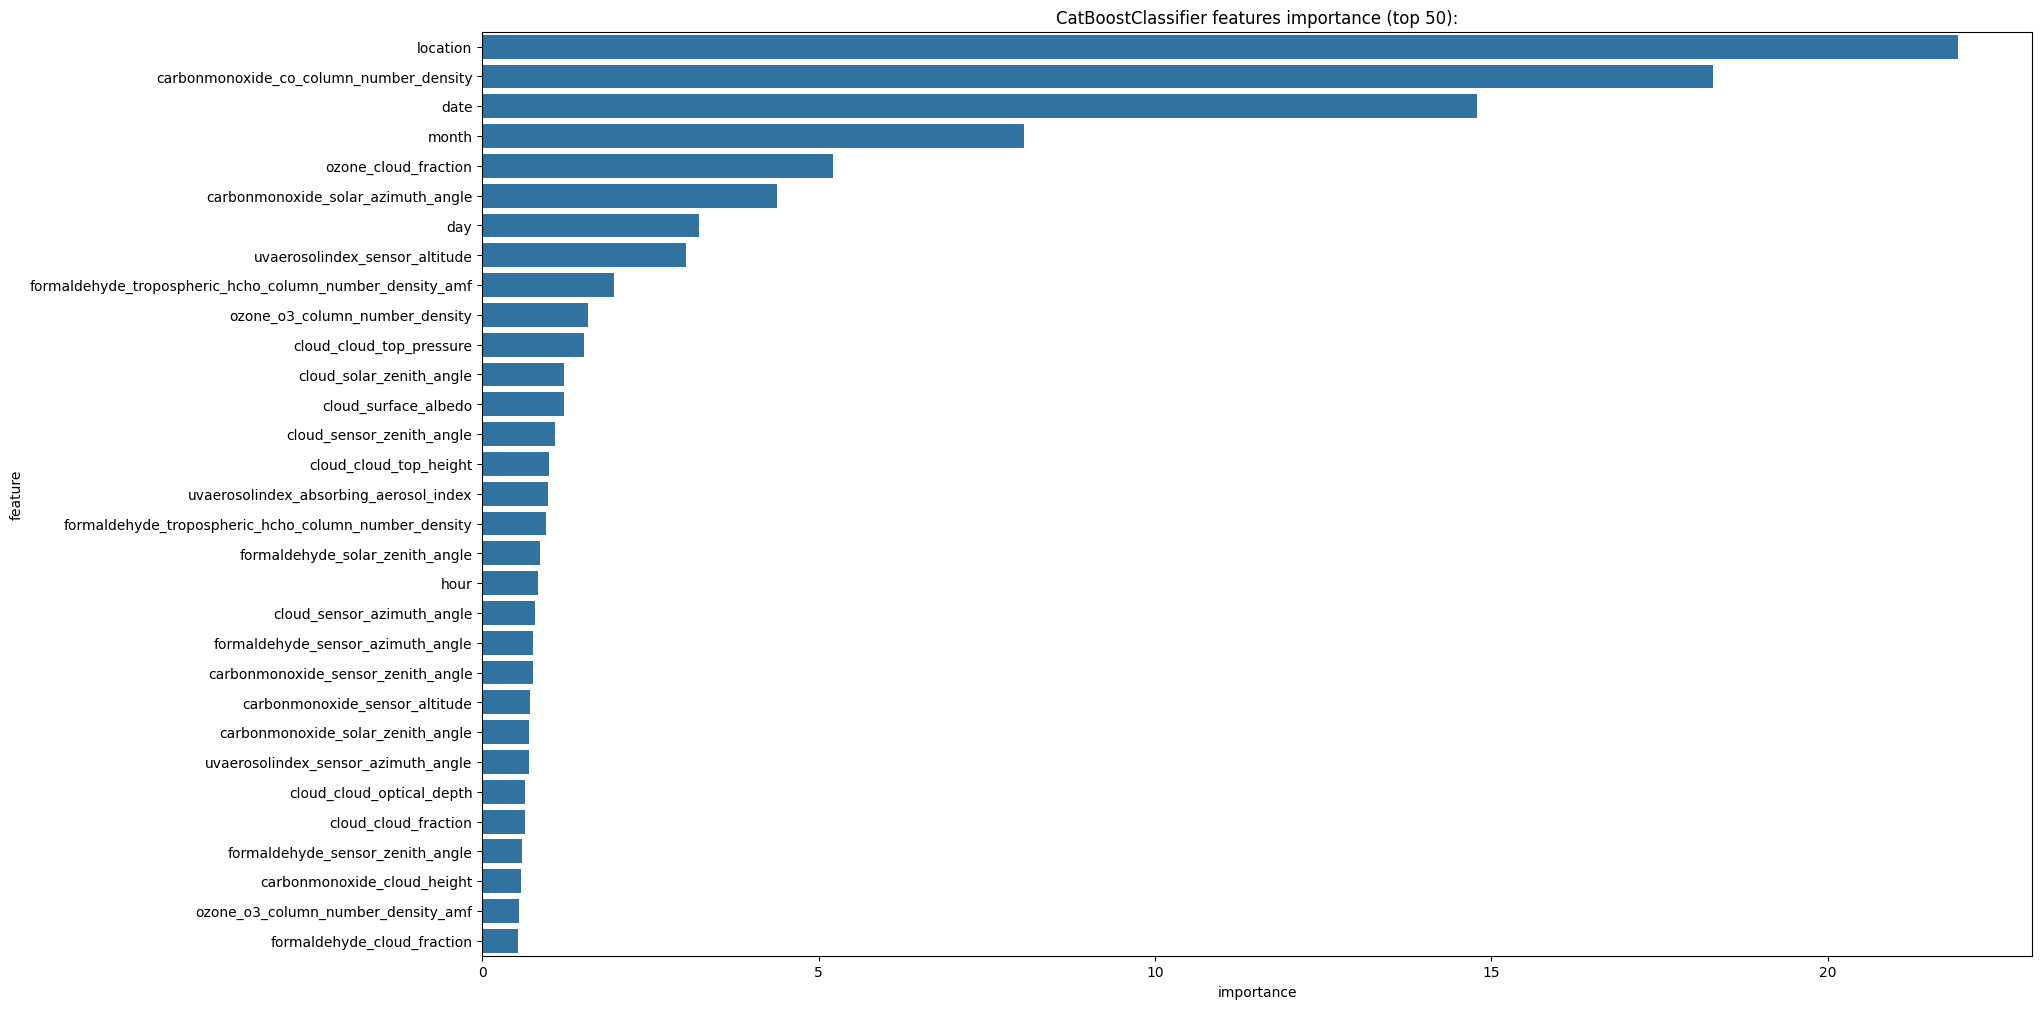

In [426]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12))
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

"""#### Submission"""

test.shape



In [427]:

pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()


,id,pred
214,id_yorywxet0a,24.597780
215,id_9rhbkh8kye,22.118304
216,id_oh2pg7ik9m,22.767184
217,id_u5xtrnbshq,22.229635
218,id_pfcdhqpggy,21.707610


In [428]:
sub.to_csv('baseline_12_64_ch.csv', index= False)


In [381]:
# !pip install catboost

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score , KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

In [383]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost as catt
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [384]:
class Config:
    path = '/content/drive/MyDrive/Colab/Airqo_starter_notebook/'#/kaggle/input/airq0-lets-get-this/AirQ0/"
    id_col = "id"
    target_col = "pm2_5"

In [385]:
train = pd.read_csv(Config.path + "Train.csv")
test = pd.read_csv(Config.path + "Test.csv")

In [386]:
# train.isnull().sum()/len(train)
train.shape, test.shape

((8071, 80), (2783, 79))

In [387]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]

    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)

    return data

train = remove_nans(train, 0.6)
test = remove_nans(test, 0.6)
train.shape, test.shape

((8071, 52), (2783, 72))

#### Setting up our Cross Validation
* GroupKFold

In [388]:
# Create folds before feature engineering
gkf = GroupKFold(n_splits = 4)
train['folds'] = np.nan
# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train.loc[test_index, 'folds'] = fold
# Convert fold indices to integer type
train['folds'] = train['folds'].astype(int)
train.groupby('folds')['pm2_5'].agg({'count'})

,count
folds,
1,5596
2,1500
3,852
4,123


In [389]:

# افترض أن train هي مجموعة البيانات الخاصة بك
# أولاً، تحقق من أنواع البيانات في مجموعة البيانات
# print(train.dtypes)

# حدد الأعمدة الرقمية فقط
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns

# حساب z-score للأعمدة الرقمية فقط
z = np.abs(stats.zscore(train[numeric_cols]))

# تعريف حد الأدنى لتحديد القيم الشاذة
threshold = 3

# تحديد الفهارس للقيم الشاذة لكل عمود رقمي
outlier_indices = []
for col in numeric_cols:
    outlier_indices.extend(np.where(z[col] > threshold)[0])

# إزالة الفهارس المكررة
outlier_indices = list(set(outlier_indices))

# طباعة عدد القيم الشاذة المحددة
print(f"Number of outliers identified: {len(outlier_indices)}")



Number of outliers identified: 218


In [390]:

# افترض أن test هي مجموعة البيانات الخاصة بك
# أولاً، تحقق من أنواع البيانات في مجموعة البيانات
# print(test.dtypes)

# حدد الأعمدة الرقمية فقط
numeric_cols = test.select_dtypes(include=['int64', 'float64']).columns

# حساب z-score للأعمدة الرقمية فقط
z = np.abs(stats.zscore(test[numeric_cols]))

# تعريف حد الأدنى لتحديد القيم الشاذة
threshold = 3

# تحديد الفهارس للقيم الشاذة لكل عمود رقمي
outlier_indices = []
for col in numeric_cols:
    outlier_indices.extend(np.where(z[col] > threshold)[0])

# إزالة الفهارس المكررة
outlier_indices = list(set(outlier_indices))

# طباعة عدد القيم الشاذة المحددة
print(f"Number of outliers identified: {len(outlier_indices)}")



Number of outliers identified: 58


In [391]:
# train[train['folds']==4]['city']

In [392]:
# train['city'].value_counts()

In [393]:
train[(train['date']=='2023-10-25') & (train['city']=='Kampala')]

,id,site_id,site_latitude,site_longitude,city,country,date,hour,month,carbonmonoxide_co_column_number_density,...,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds
421,id_bnzz82vs1f,60d058c8048305120d2d6156,0.351700,32.591000,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,36683.276504,8415.787831,4.991480,0.307167,-99.635167,38.030097,-112.729436,33.768916,10.72830,1
568,id_hsain920tf,60d058c8048305120d2d615a,0.218200,32.617600,Kampala,Uganda,2023-10-25,11,10.0,0.033298,...,49297.640625,5987.647461,8.670818,0.184457,-99.659988,37.900917,-112.521225,33.712029,16.58720,1
825,id_hse0aqv6dj,616fe4ce9657420029658b3e,0.405320,32.620270,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,75042.937500,2625.331299,8.315380,0.346472,-99.614647,38.204361,-112.789452,33.809303,13.98560,1
1208,id_elqte0s1z1,64a5755320511a001d1b4a3e,0.329891,32.598999,Kampala,Uganda,2023-10-25,11,10.0,NaN,...,43098.839844,7044.871094,7.826046,0.259927,-99.651337,37.900677,-112.666084,33.735855,11.10380,1
1430,id_5pa9pq67xp,62b310512e0eca001e0aab11,0.298330,32.600740,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43138.459117,7037.917190,7.803655,0.259759,-99.648982,37.925970,-112.664331,33.739966,23.45730,1
1673,id_5xxfee2icn,60d058c8048305120d2d615c,0.356400,32.573000,Kampala,Uganda,2023-10-25,11,10.0,0.031926,...,32811.738281,9193.101563,4.563959,0.307819,-99.647224,37.900757,-112.738457,33.747902,47.34780,1
1934,id_fen86w6ue2,624d2f9a994194001ddccbb6,0.288630,32.602970,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43805.826209,6946.381884,7.491056,0.259607,-99.652445,37.900689,-112.647128,33.732724,15.57630,1
2198,id_5bylowr7h6,60d058c8048305120d2d6154,0.344000,32.553000,Kampala,Uganda,2023-10-25,11,10.0,NaN,...,32811.738281,9193.101562,4.563959,0.307819,-99.647224,37.900757,-112.738457,33.747902,24.33010,1
2711,id_j11a8zijyz,623d83620e8054001eaaa982,0.308520,32.592240,Kampala,Uganda,2023-10-25,11,10.0,0.032589,...,43098.839844,7044.871094,7.826046,0.259927,-99.651337,37.900677,-112.666084,33.735855,25.06490,1
2915,id_f6jt57bht5,60d058c8048305120d2d6149,0.347014,32.649360,Kampala,Uganda,2023-10-25,11,10.0,0.034574,...,42207.379485,7323.031424,5.606781,0.306071,-99.618637,38.207406,-112.717067,33.797726,16.31450,1


In [394]:
def feature_engineering(train,test):
    train = train.fillna(method='ffill')
    test = test.fillna(method='ffill')
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')

    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week


    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])





#     data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train, test)

In [395]:
test_df[independent_features].isnull().sum()

date                                                        0
hour                                                        0
month                                                       0
carbonmonoxide_co_column_number_density                     0
carbonmonoxide_h2o_column_number_density                    0
carbonmonoxide_cloud_height                                 0
carbonmonoxide_sensor_altitude                              0
carbonmonoxide_sensor_azimuth_angle                         0
carbonmonoxide_sensor_zenith_angle                          0
carbonmonoxide_solar_azimuth_angle                          0
carbonmonoxide_solar_zenith_angle                           0
formaldehyde_tropospheric_hcho_column_number_density        0
formaldehyde_tropospheric_hcho_column_number_density_amf    0
formaldehyde_hcho_slant_column_number_density               0
formaldehyde_cloud_fraction                                 0
formaldehyde_solar_zenith_angle                             0
formalde

In [396]:
# train_df['location'].value_counts()

### Modelling : Stage 1

In [397]:
training  = train_df[train_df['folds'].isin([1.0,3.0, 4.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape

((6571, 79), (1500, 79))

In [398]:
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )

Learning rate set to 0.068433
0:	learn: 24.2725268	test: 25.8358055	best: 25.8358055 (0)	total: 12.3ms	remaining: 12.3s
100:	learn: 12.9049275	test: 25.1323577	best: 25.0834642 (33)	total: 1.72s	remaining: 15.3s
200:	learn: 9.9324273	test: 25.1749925	best: 25.0834642 (33)	total: 4.34s	remaining: 17.2s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 25.08346422
bestIteration = 33

Shrink model to first 34 iterations.


25.173082 - 24.82027147 -  24.80945577

#### Visualize feature importance

In [399]:
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted,
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
66,location,59.809001
3,carbonmonoxide_co_column_number_density,13.373239
0,date,3.849121
70,week,2.5542
32,ozone_solar_azimuth_angle,1.970295
23,uvaerosolindex_solar_azimuth_angle,1.795777
9,carbonmonoxide_solar_azimuth_angle,1.476604
29,ozone_cloud_fraction,1.476236
43,cloud_solar_azimuth_angle,1.433557
12,formaldehyde_tropospheric_hcho_column_number_d...,1.388729


In [400]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

array(['date', 'hour', 'month', 'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density_amf',
       'formaldehyde_hcho_slant_column_number_density',
       'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
       'formaldehyde_sensor_zenith_angle',
       'formaldehyde_sensor_azimuth_angle',
       'uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude',
       'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_solar_azimuth_angle',
       'ozone_o3_column_number_density',
       'ozone_o3_column_number_density_amf',
       'ozone_o3_slant_column_number_density', 'ozone_cloud_fraction',
       'ozone_sensor_azimuth_angle'

In [401]:
len(non_zero_features)

45

#### Dropping all highly correlated features

In [402]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]
selected_columns

Index(['date', 'hour', 'month', 'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density_amf',
       'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
       'formaldehyde_sensor_zenith_angle', 'formaldehyde_sensor_azimuth_angle',
       'uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
       'ozone_o3_column_number_density', 'ozone_o3_column_number_density_amf',
       'ozone_cloud_fraction', 'cloud_cloud_fraction',
       'cloud_cloud_top_pressure', 'cloud_cloud_top_height',
       'cloud_cloud_optical_depth', 'cloud_surface_albedo',
       'cloud_sensor_azimuth_angle', 'cloud_sensor_z

In [403]:
len(selected_columns)

31

#### ROBUST CV: GROUPKFOLD

In [404]:
fold_pred = []
oof_pred = []

for fold in [1,2,3,4]:
    print("*" * 100)
    df_train = train_df.copy()
    df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

    training = df_train[train_df['folds'] != fold]
    validation = df_train[df_train['folds'] == fold]



    #training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
    model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 200, early_stopping_rounds = 250 )

    preds = model.predict(X_test)
    print(f"RMSE for fold :{fold} : {(mean_squared_error(preds, y_test, squared=False))}")
    oof_pred.append(mean_squared_error(preds, y_test, squared=False))

    #Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)



print(f"The average rmse across the 4 groups: {np.mean(oof_pred)}")



****************************************************************************************************
Learning rate set to 0.058707
0:	learn: 16.6132825	test: 13.1588337	best: 13.1588337 (0)	total: 6.77ms	remaining: 6.76s
200:	learn: 6.9633849	test: 12.4014780	best: 12.0542066 (38)	total: 1.44s	remaining: 5.74s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 12.05420662
bestIteration = 38

Shrink model to first 39 iterations.
RMSE for fold :1 : 12.054206418400264
****************************************************************************************************
Learning rate set to 0.068433
0:	learn: 14.4274617	test: 13.1596572	best: 13.1596572 (0)	total: 7.44ms	remaining: 7.43s
200:	learn: 6.9534198	test: 11.6365349	best: 11.5535006 (166)	total: 1.57s	remaining: 6.23s
400:	learn: 5.6623577	test: 11.9020552	best: 11.5535006 (166)	total: 3.1s	remaining: 4.63s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 11.5535006
bestIteration = 166

Shrink mode

city
Kampala      5596
Nairobi      1500
Lagos         852
Bujumbura     123

#### CV - LEADERBOARD CORRELATION
* 28.100770660507774 - 14.65282282
* 27.162630896494314 - 14.39405375
* 26.954972506037006 - 14.36
* 27.802500703999304 - 13.94



28.100770660507774

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

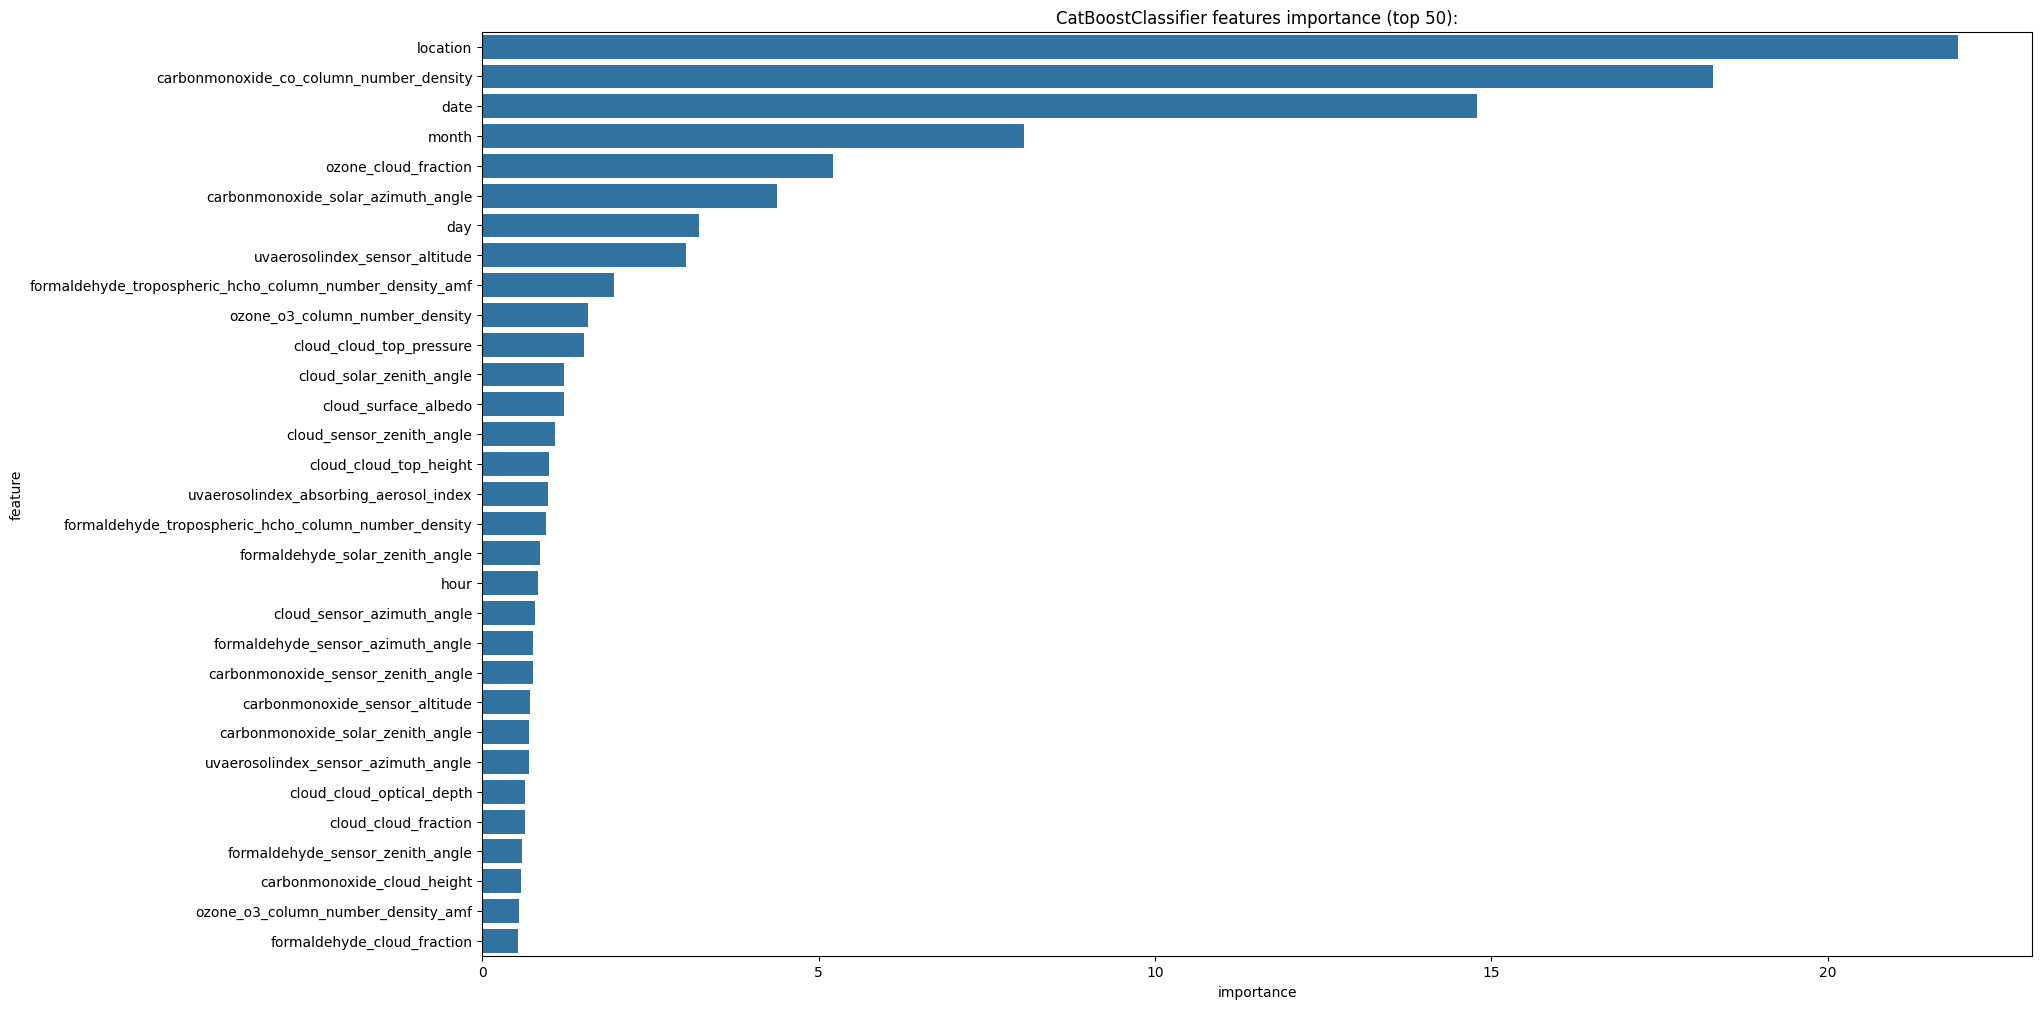

In [405]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

#### Submission

In [406]:
test.shape

(2783, 72)

In [407]:
pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()

,id,pred
214,id_yorywxet0a,24.597780
215,id_9rhbkh8kye,22.118304
216,id_oh2pg7ik9m,22.767184
217,id_u5xtrnbshq,22.229635
218,id_pfcdhqpggy,21.707610


In [408]:
sub.to_csv('baseline_12_64.csv', index= False)